## 1.1 安裝套件(若在colab訓練每次都需要執行)

In [ ]:
!pip install fastbook -q
!pip install timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1.2 讀取套件

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import shutil
import fastai;
print('fastai verison:', fastai.__version__)
print('torch version:', torch.__version__)

fastai verison: 2.7.19
torch version: 2.6.0+cu124



## 1.3 準備資料集

In [ ]:
from google.colab import drive #掛載雲端硬碟
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set project name
project = 'weatherdataset'

path = Path('/content/drive/MyDrive/SDG/'+project)

#Key is the name of classes; value is the keyword that which search engine uses for searching
keywords = {'drought': '乾旱', 'sandstorm': '沙塵暴', 'tsunami ':['Tsunami','海嘯',] ,'raining ': '下雨','tornado': '龍捲風'}
array = keywords.items()

project_folder = f'/content/drive/MyDrive/SDG/'+project

In [ ]:
!pip install duckduckgo_search
from duckduckgo_search import DDGS
from fastcore.all import *

#GPT:duckduckgo_search 庫提供了一種與 DuckDuckGo 圖片搜索 API 交互的更更新的方法。
if not path.exists():
    !mkdir -p {project_folder}
else:
    print('The Project Folder exists; it will be removed and created again.')
    shutil.rmtree(project_folder)
    !mkdir -p {project_folder}

#網路爬蟲下載圖片
for key,value in array:
    print(key,value)
    dest = (path/key)
    dest.mkdir(exist_ok=True)
    refined_query = f"{value} -cartoon -illustration -anime -fake -music " #GPT: 增加以及撤銷的限制

    urls = search_images_ddg(f' {value}',max_images=170)
    filtered_urls = [url for url in urls if not any(kw in url.lower() for kw in ["cartoon", "illustration", "anime", "fake"])] #過濾卡通
    if len(urls) < 100:
      print(f"Warning: Only found {len(urls)} images for {value}")

    download_images(dest, urls=urls)

The Project Folder exists; it will be removed and created again.
drought 乾旱
sandstorm 沙塵暴
Tsunami  海嘯
raining  下雨
Snowfall 雪


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.4 清洗資料

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink) #unlink broken images

(#46) [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None...]

##2.1設定訓練資料路徑

In [ ]:
path = Path('/content/drive/MyDrive/SDG/weatherdataset')


In [ ]:
#view all files inn directory 抓取總照片資料路徑
# ---------- 分割資料集為 train/val/test (8:1:1) ---------- GPT
from pathlib import Path
import shutil, random

def quick_split(path, output_path, ratio=(0.8, 0.1, 0.1)):
    path, output_path = Path(path), Path(output_path)
    classes = [p.name for p in path.iterdir() if p.is_dir()]

    for cls in classes:
        imgs = list((path/cls).iterdir())
        random.shuffle(imgs)
        n = len(imgs)
        train, val = int(n*ratio[0]), int(n*(ratio[0]+ratio[1]))
        sets = {'train': imgs[:train], 'val': imgs[train:val], 'test': imgs[val:]}

        for setname, files in sets.items():
            dest = output_path/setname/cls
            dest.mkdir(parents=True, exist_ok=True)
            for f in files:
                shutil.copy(f, dest)

    print("✅ 快速分割完成！")
quick_split('/content/drive/MyDrive/SDG/weatherdataset', '/content/drive/MyDrive/SDG/split_weatherdataset')

path.ls()

In [ ]:
#建立模型權重儲存路徑
myPath='/content/drive/MyDrive/SDG/models' ##會自動新增model資料夾
!mkdir -p $myPath

##2.2. 資料讀取框架

In [ ]:
from fastai.vision.all import * #參考GPT

path = Path('/content/drive/MyDrive/SDG/split_weatherdataset')

# 這行會去 path/train 和 path/val 自動讀資料
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='val',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
    bs=16,  # 可調整
    num_workers=4  # Colab 記得設小一點，16 太大會炸掉
)


#讀取結果
print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds))

5 ['drought', 'raining ', 'sandstorm', 'tornado', 'tsunami'] 601 119


In [ ]:
test_path = Path('/content/drive/MyDrive/SDG/split_weatherdataset/test')
test_dl = dls.test_dl(get_image_files(test_path), with_labels=True)

##2.3. 讀取圖檔結果

訓練資料


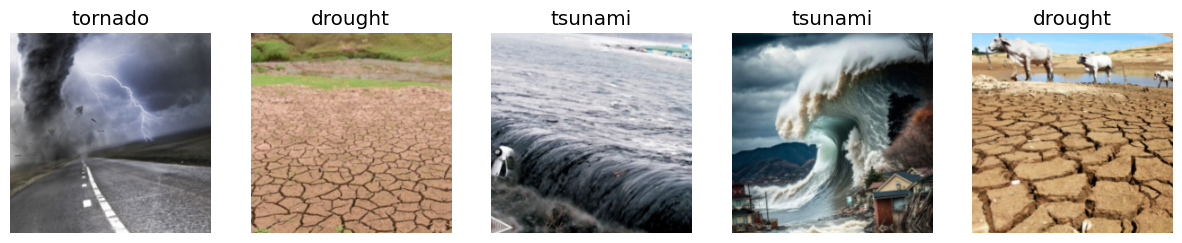

In [ ]:
print('訓練資料')
dls.show_batch(max_n=5, nrows=1)

## 3.1. 選擇模型架構以及對應的預訓練權重

### Note: metrics是模型訓練人員觀察的指標, 可設定多個 ResNet50 GG16 EfficientNet B0


In [ ]:
learn_resnet = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], pretrained=True)
learn_vgg = vision_learner(dls, vgg16_bn, metrics=[accuracy, error_rate], pretrained=True)
learn_effnet = vision_learner(dls, efficientnet_b0, metrics=[accuracy, error_rate], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.9MB/s]
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn

In [ ]:
learn_resnet.summary #印出模型摘要
learn_vgg.summary
learn_effnet.summary

<bound method Learner.summary of <fastai.learner.Learner object at 0x782f47c281d0>>

In [ ]:
learn_resnet.fit_one_cycle(3, lr_max=1e-3)
learn_vgg.fit_one_cycle(3, lr_max=1e-3)
learn_effnet.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.840314,0.429374,0.848740,0.151261,00:35
1,1.120425,0.287625,0.915966,0.084034,00:24
2,0.811398,0.279005,0.915966,0.084034,00:25


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.785559,0.462700,0.873950,0.126050,00:24
1,1.058103,0.309240,0.907563,0.092437,00:25
2,0.823299,0.243716,0.924370,0.075630,00:26


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.670109,0.617930,0.823529,0.176471,00:26
1,1.079354,0.454423,0.865546,0.134454,00:23
2,0.793830,0.386233,0.890756,0.109244,00:25


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


##3.2 儲存第一次訓練好的權重

In [ ]:
myModel = myPath + '/resnet34_stage-1'
learn_resnet.save(myModel)
learn_resnet.export(f'{myPath}/resnet34_stage-1.pkl')

myModel = myPath + '/vggstage-1'
learn_vgg.save(myModel)
learn_vgg.export(f'{myPath}/vggstage-1.pkl')

myModel = myPath + '/effnetstage-1'
learn_effnet.save(myModel)
learn_effnet.export(f'{myPath}/effnetstage-1.pkl')

# save 只存權重	.pth  export整個模型.pkl

#這邊以下會在另一個分頁//////////////

